## Anomaly Detection using Isolation Forest

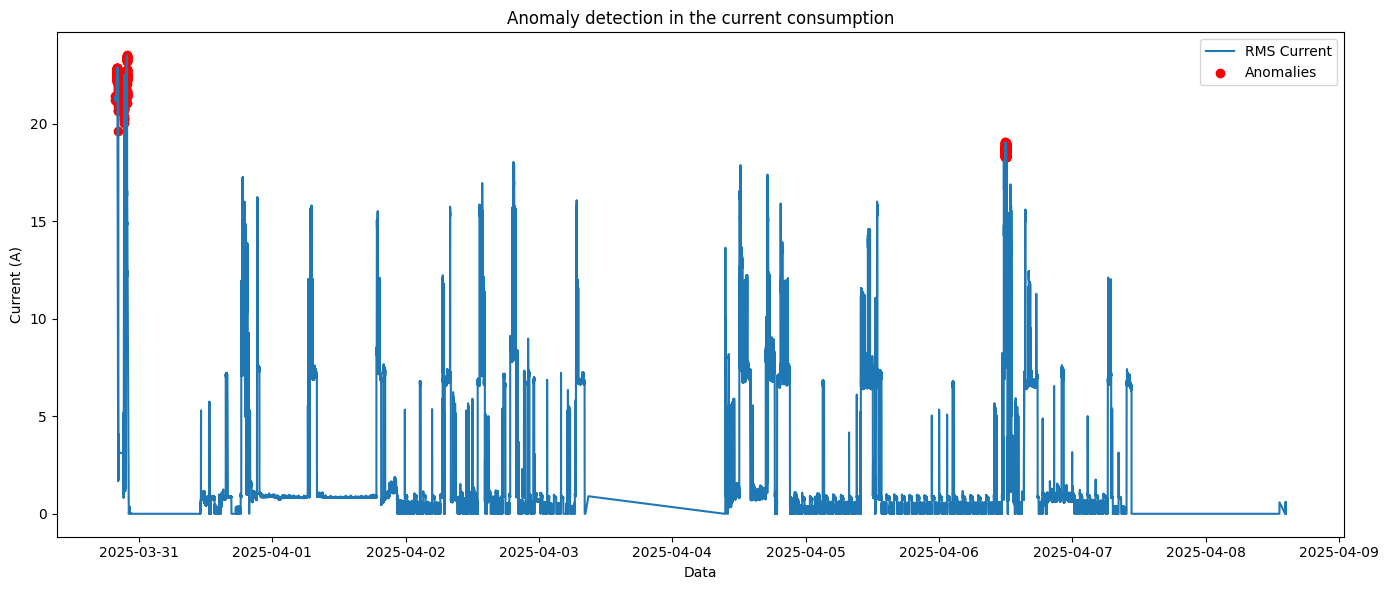

Model e scaler saved.


In [71]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import joblib

# query the database
DB_PATH = 'deepwatt.db'
conn = sqlite3.connect(DB_PATH)

query = """
SELECT timestamp, rms_current
FROM device_readings
WHERE rms_current IS NOT NULL AND device_id= 'board-cc:50:e3:60:e6:80'
ORDER BY timestamp ASC
"""
df = pd.read_sql_query(query, conn)
conn.close()

# convert timestamp to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('datetime', inplace=True)

# remove some extreme outliers ( > 200 A) 
df = df[(df['rms_current'] >= 0) & (df['rms_current'] < 200)]

# Opcional: aplicar média móvel (suavização)
# df['rms_current'] = df['rms_current'].rolling(window=3, center=True).mean().dropna()

# normalize the data
scaler = StandardScaler()
df['current_scaled'] = scaler.fit_transform(df[['rms_current']])

# train the model
model = IsolationForest(n_estimators=100, contamination=0.002, random_state=42) # the smaller the contamination, less points will be considered an anomaly -> the proportion of outliers in the data set. Used when fitting to define the threshold on the scores of the samples.
model.fit(df[['current_scaled']])

# test with the same training data
df['anomaly'] = model.predict(df[['current_scaled']])  # -1 = anomaly, 1 = normal

# Visualize
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['rms_current'], label='RMS Current')
plt.scatter(df[df['anomaly'] == -1].index,
            df[df['anomaly'] == -1]['rms_current'],
            color='red', label='Anomalies')
plt.legend()
plt.title("Anomaly detection in the current consumption")
plt.xlabel("Data")
plt.ylabel("Current (A)")
plt.tight_layout()
plt.show()

# Save the model and the scale
joblib.dump(model, 'anomaly_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Model e scaler saved.")


### Forecaster

MAE nos últimos 10 minutos: 0.119 A


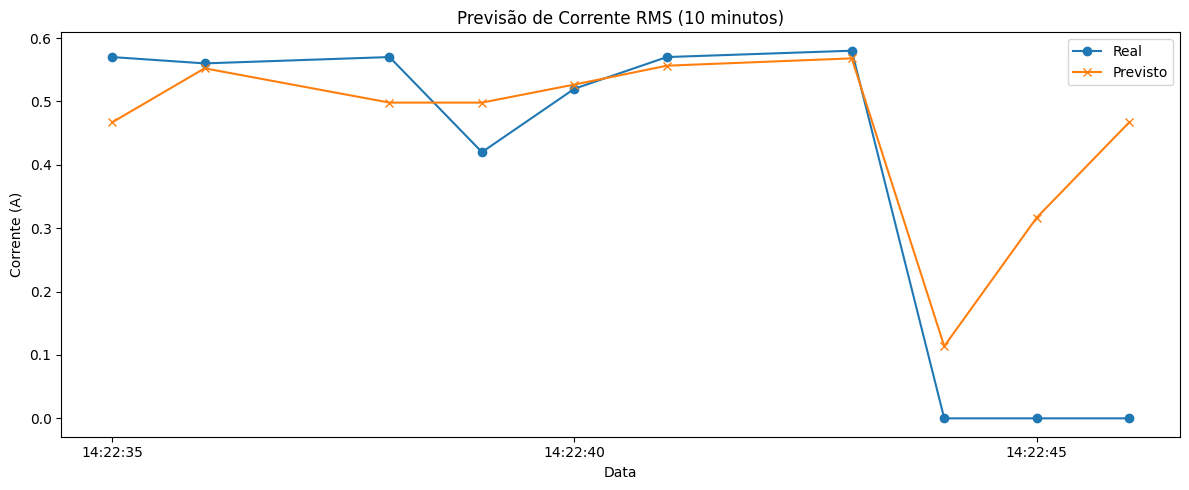

['forecast_scaler.pkl']

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import joblib


DB_PATH = 'deepwatt.db'
DEVICE_ID = 'board-cc:50:e3:60:e6:80'
FORECAST_MINUTES = 10

conn = sqlite3.connect(DB_PATH)
query = f"""
SELECT timestamp, rms_current
FROM device_readings
WHERE rms_current IS NOT NULL AND device_id = '{DEVICE_ID}'
ORDER BY timestamp ASC
"""
df = pd.read_sql_query(query, conn)
conn.close()


df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('datetime', inplace=True)
df = df[(df['rms_current'] >= 0) & (df['rms_current'] < 200)]

# time features
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['day_of_week'] = df.index.dayofweek
df['mean_5'] = df['rms_current'].rolling(window=5, min_periods=1).mean()
df['std_5'] = df['rms_current'].rolling(window=5, min_periods=1).std().fillna(0)

# TARGET: 10 min ahead 
df['target'] = df['rms_current'].shift(-FORECAST_MINUTES)

df.dropna(inplace=True)

features = ['rms_current', 'mean_5', 'std_5', 'hour', 'minute', 'day_of_week']
X = df[features]
y = df['target']


test_final = df.iloc[-FORECAST_MINUTES:]
X_final = test_final[features]
y_final = test_final['target']



scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_final_scaled = scaler.transform(X_final)


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_scaled, y)


y_pred = model.predict(X_final_scaled)


mae = mean_absolute_error(y_final, y_pred)
print(f"MAE nos últimos 10 minutos: {mae:.3f} A")


plt.figure(figsize=(12, 5))
plt.plot(y_final.index, y_final.values, label='Real', marker='o')
plt.plot(y_final.index, y_pred, label='Previsto', marker='x')
plt.title("Previsão de Corrente RMS (10 minutos)")
plt.xlabel("Data")
plt.ylabel("Corrente (A)")
plt.legend()
plt.tight_layout()
plt.show()

# === GUARDAR MODELO E SCALER ===
joblib.dump(model, 'current_forecast_model.pkl')
joblib.dump(scaler, 'forecast_scaler.pkl')
